In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns

from matplotlib import gridspec
from scipy import sparse, special, stats
from theano import tensor as tt

%config InlineBackend.figure_format = 'retina'
warnings.simplefilter(action="ignore", category=FutureWarning)
RANDOM_SEED = 8927
np.random.seed(286)

In [2]:
az.style.use("arviz-darkgrid")

# Chapter 3 - Inferences with binomials
## 3.1 Inferring a rate


Inferring the rate $\theta$ of a binary process  
$$ \theta \sim \text{Beta}(1, 1)  $$
$$ k \sim \text{Binomial} ( \theta, n)  $$

In the example, we set k = 5 and n = 10

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


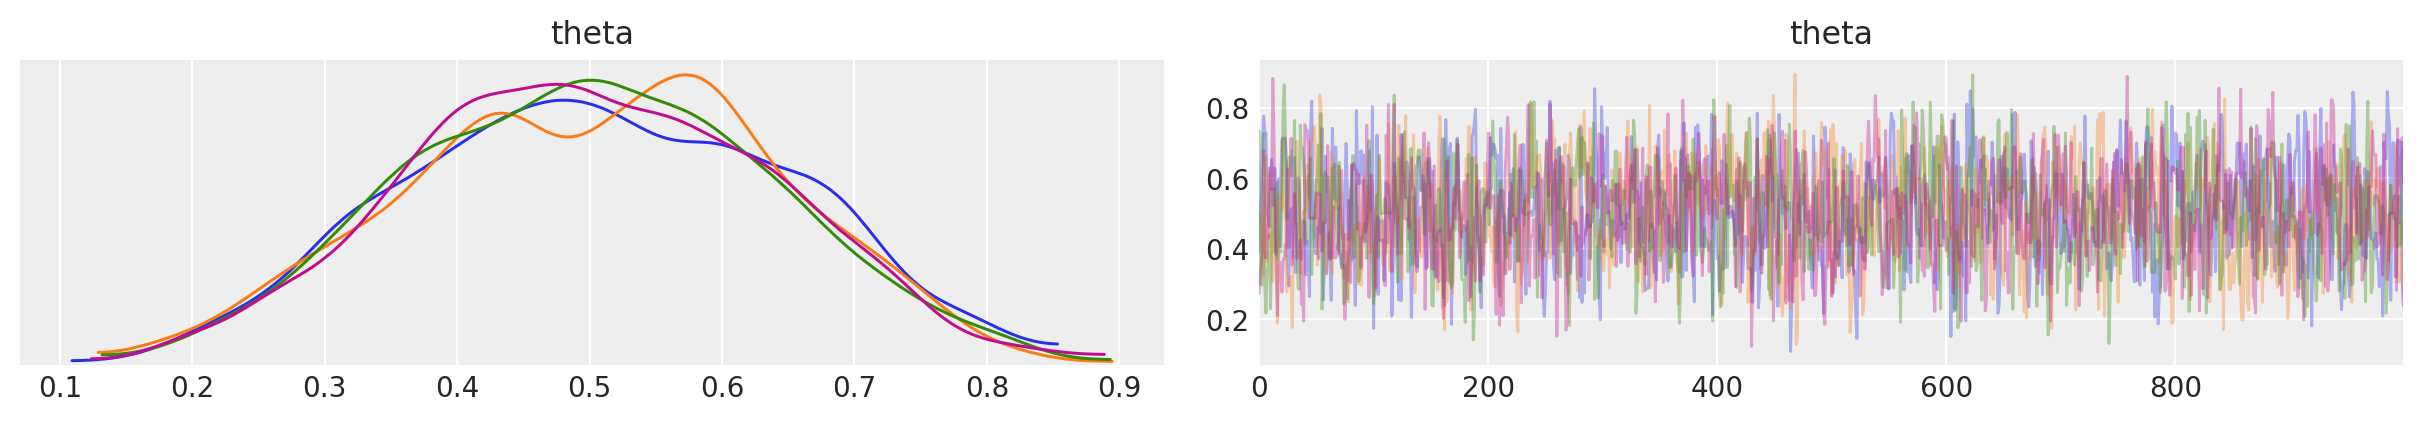

In [3]:
# Data
k = np.array([5])
n = np.array([10])

with pm.Model() as model1:
    # prior
    theta = pm.Beta("theta", alpha=1, beta=1)
    # observed
    x = pm.Binomial("x", n=n, p=theta, observed=k)
    # inference
    trace1 = pm.sample()

idata1 = az.from_pymc3(trace1)
az.plot_trace(idata1, var_names=["theta"]);

And generate a picture that is identical to 3.2 one on page 39 of Wagenmakers, 2013:

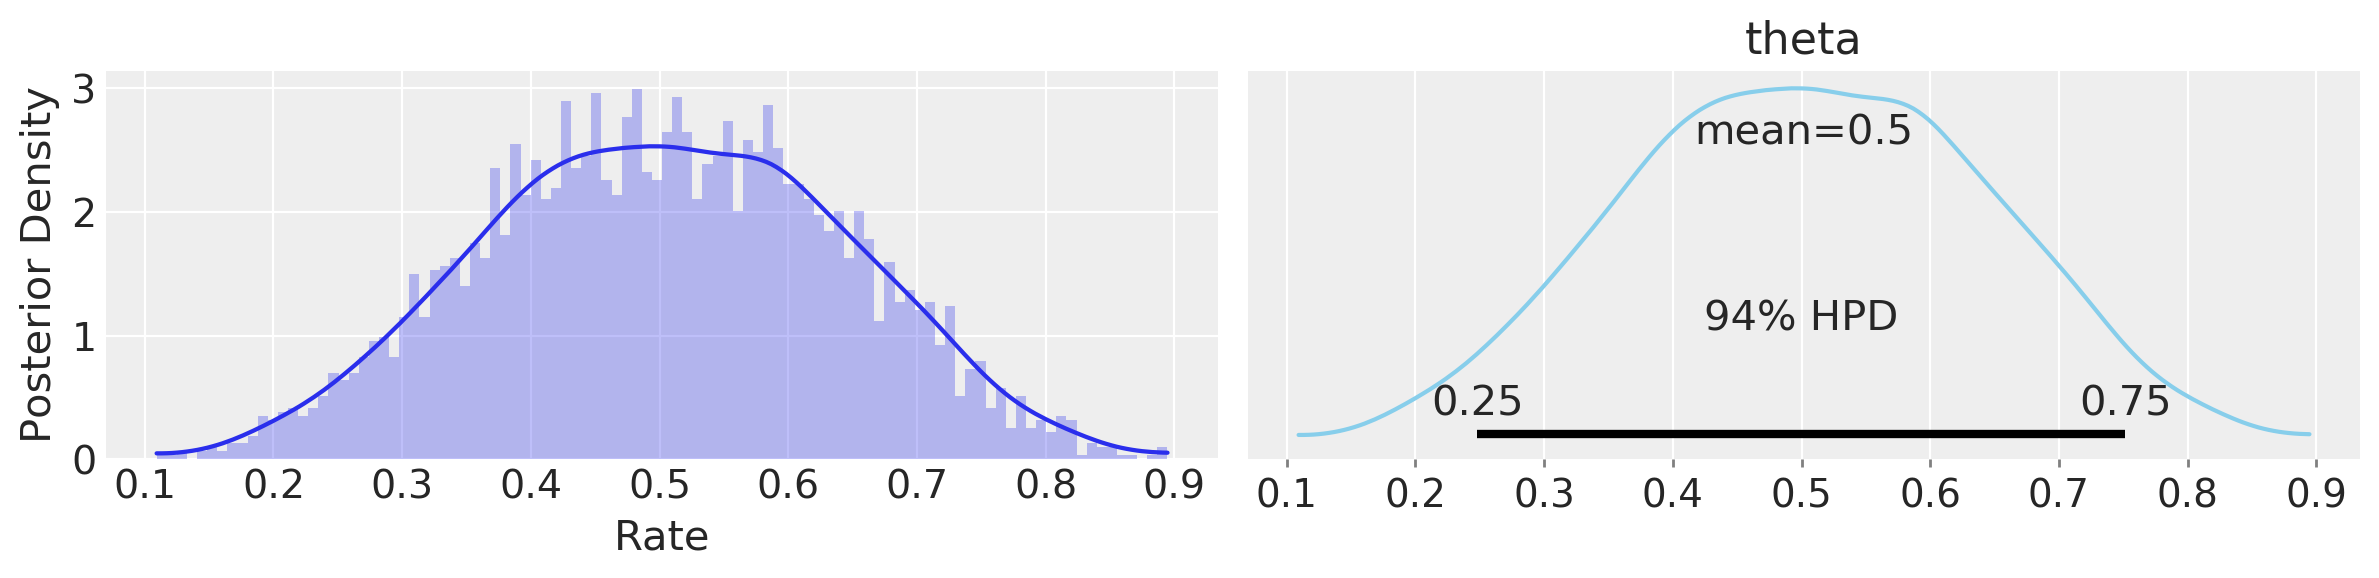

In [4]:
_, axes = plt.subplots(1, 2, figsize=(12, 3))

az.plot_kde(trace1["theta"], ax=axes[0])
axes[0].hist(trace1["theta"], bins=100, density=1, alpha=0.3)
axes[0].set_xlabel("Rate")
axes[0].set_ylabel("Posterior Density")

az.plot_posterior(idata1, var_names=["theta"], ax=axes[1], color="#87ceeb")
plt.tight_layout();

In [5]:
az.summary(
    idata1, var_names=["theta"], round_to=3
)  # gives the same credible interval as in the book.

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
theta,0.502,0.138,0.248,0.752,0.003,0.002,2015.73,2015.73,2058.05,3097.553,1.001


## 3.2 Difference between two rates

Inferring the rate $\theta$ of two binary process  
$$ \theta \sim \text{Beta}(1, 1)  $$
$$ k \sim \text{Binomial} ( \theta, n)  $$

In the example, we set k1 = 5, n1 = 10 and k2 = 7, n2 = 10 

The model involve a deterministic part in pymc3.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta2, theta1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


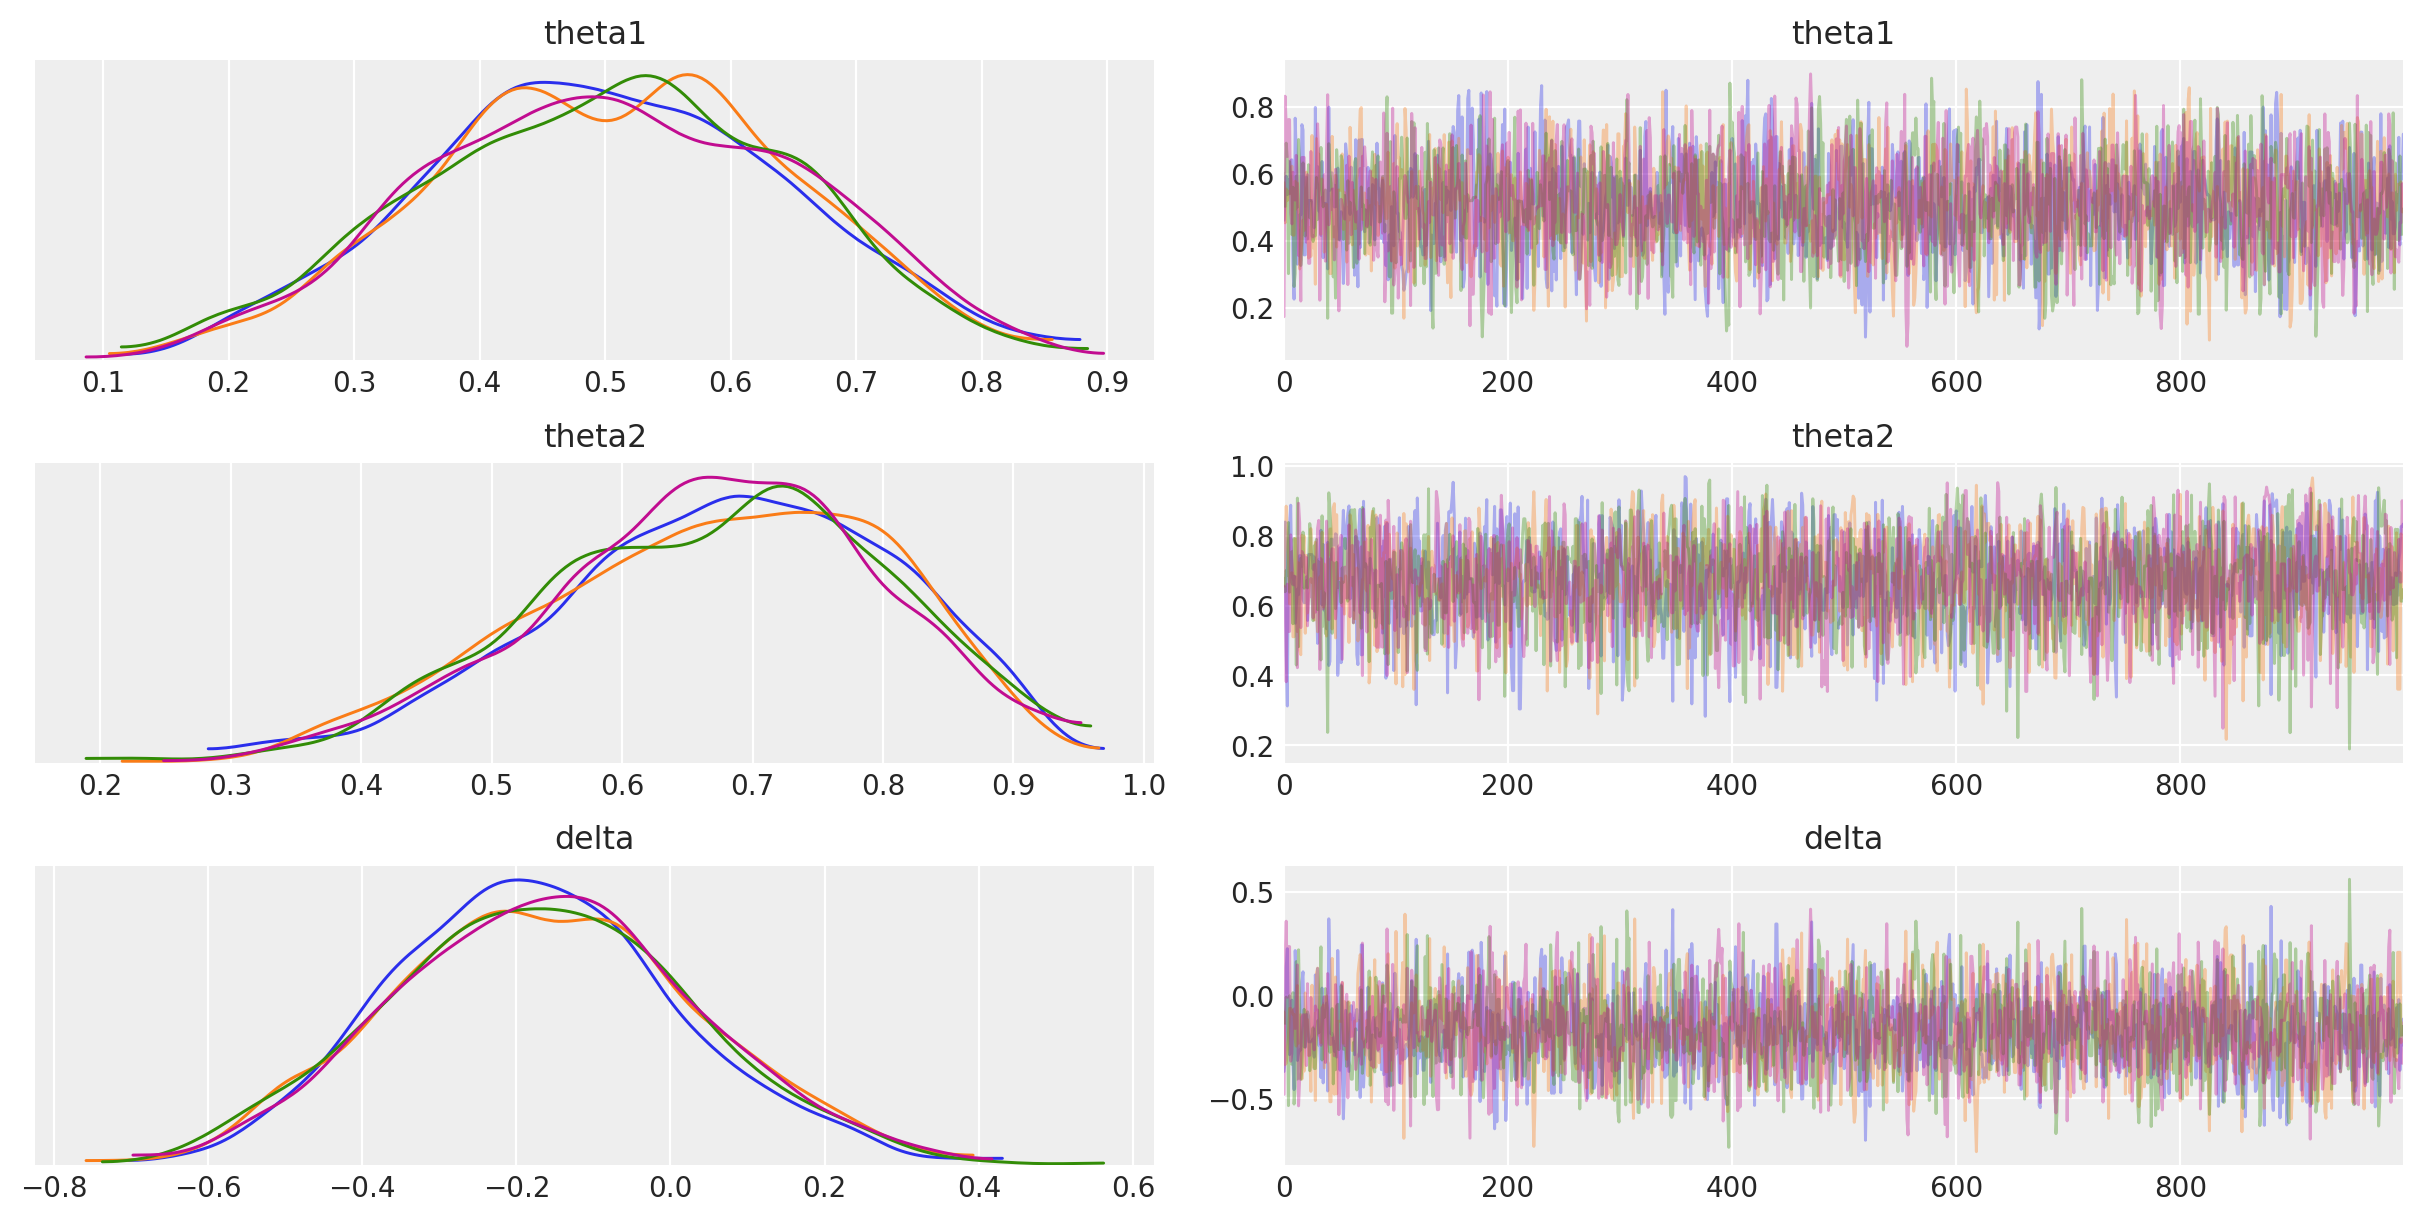

In [6]:
# data
k1, k2 = 5, 7
n1 = n2 = 10

with pm.Model() as model2:
    # prior
    theta1 = pm.Beta("theta1", alpha=1, beta=1)
    theta2 = pm.Beta("theta2", alpha=1, beta=1)
    # observed
    x1 = pm.Binomial("x1", n=n1, p=theta1, observed=k1)
    x2 = pm.Binomial("x2", n=n2, p=theta2, observed=k2)
    # differences as deterministic
    delta = pm.Deterministic("delta", theta1 - theta2)
    # inference
    trace2 = pm.sample()

idata2 = az.from_pymc3(trace2)
az.plot_trace(idata2);

In [7]:
az.summary(idata2)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
theta1,0.504,0.144,0.251,0.782,0.002,0.002,3386.0,3376.0,3389.0,2525.0,1.0
theta2,0.671,0.131,0.420,0.892,0.002,0.002,3551.0,3323.0,3373.0,2443.0,1.0
delta,-0.167,0.193,-0.519,0.210,0.003,0.003,3471.0,2707.0,3461.0,2664.0,1.0


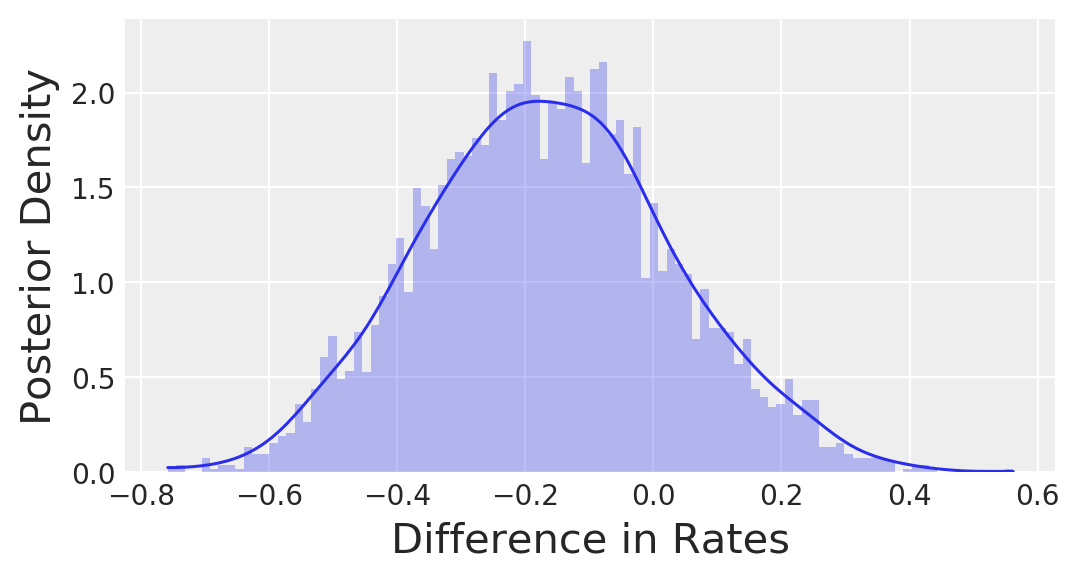

In [8]:
_, axes = plt.subplots(1, 1, figsize=(6, 3))

az.plot_kde(trace2["delta"], ax=axes)
axes.hist(trace2["delta"], bins=100, density=1, alpha=0.3)
axes.set_xlabel("Difference in Rates")
axes.set_ylabel("Posterior Density");

## 3.3 Inferring a common rate

In [9]:
# Multiple trials
k = np.array([5, 7])
n = np.array([10, 10])

with pm.Model() as model3:
    # prior
    theta = pm.Beta("theta", alpha=1, beta=1)
    # observed
    x = pm.Binomial("x", n=n, p=theta, observed=k)
    # inference
    trace3 = pm.sample()

idata3 = az.from_pymc3(trace3)
az.summary(idata3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
theta,0.591,0.1,0.411,0.781,0.003,0.002,1581.0,1552.0,1588.0,2521.0,1.0


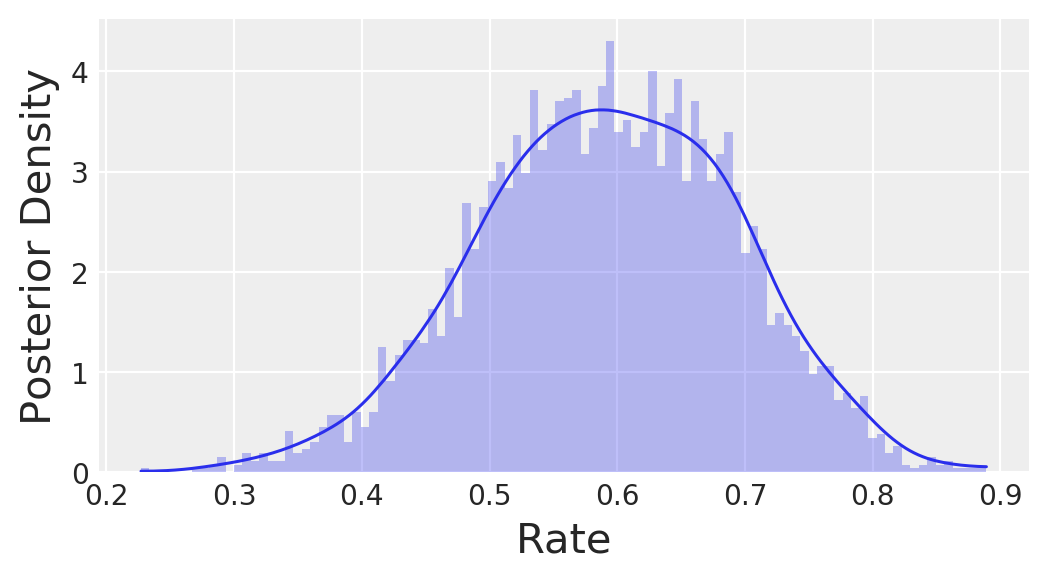

In [10]:
_, axes = plt.subplots(1, 1, figsize=(6, 3))

az.plot_kde(trace3["theta"], ax=axes)
axes.hist(trace3["theta"], bins=100, density=1, alpha=0.3)

axes.set_xlabel("Rate")
axes.set_ylabel("Posterior Density");

## 3.4 Prior and posterior prediction

In [11]:
k = 1
n = 15
# Uncomment for Trompetter Data
# k = 24
#  n = 121

with pm.Model() as model_obs:
    theta = pm.Beta("theta", alpha=1, beta=1)
    x = pm.Binomial("x", n=n, p=theta, observed=k)

    priors = pm.sample_prior_predictive()
    trace_obs = pm.sample()
    ppc = pm.sample_posterior_predictive(trace_obs)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


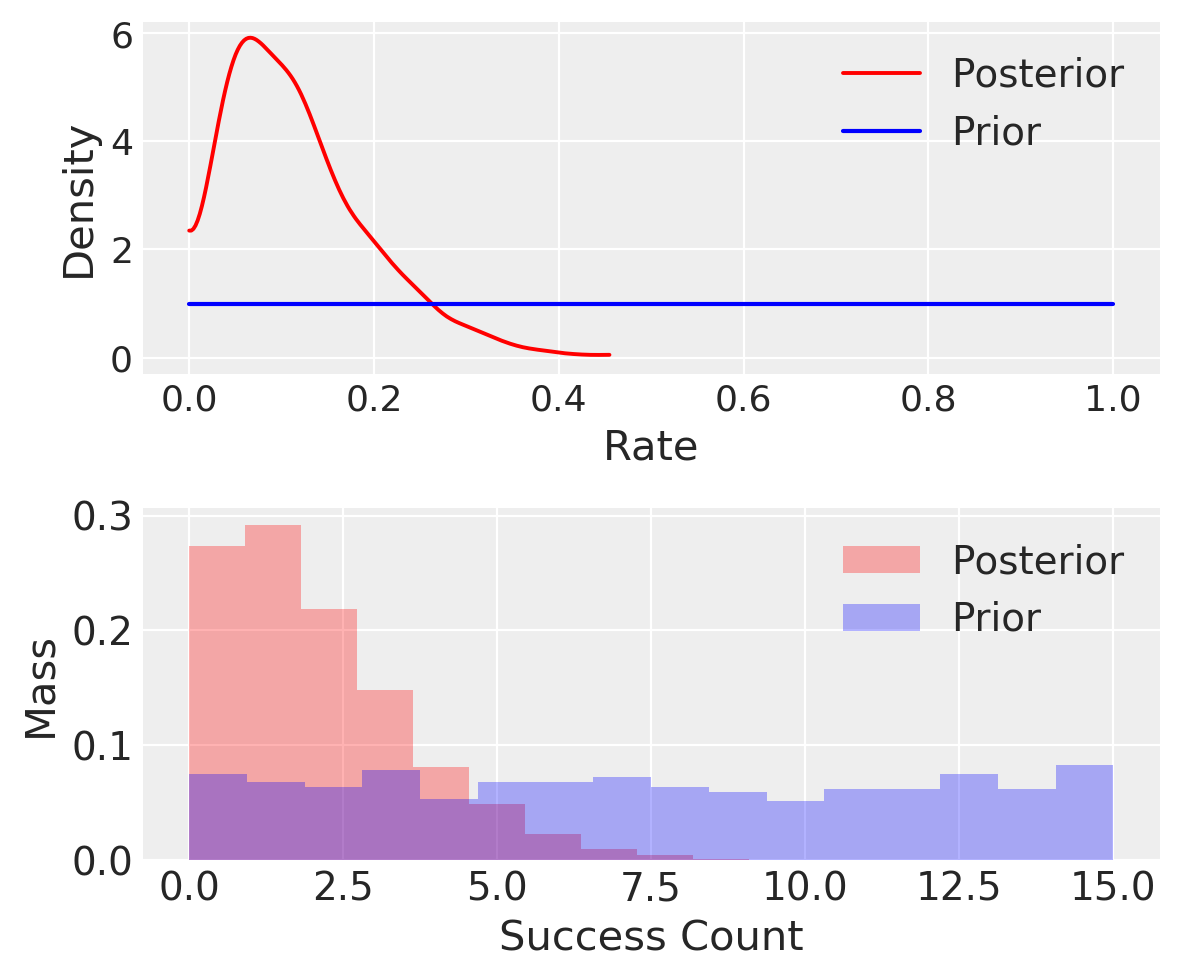

In [12]:
prior_x = priors["x"]
pred_theta = trace_obs["theta"]

_, axes = plt.subplots(2, 1, figsize=(6, 5))

az.plot_kde(pred_theta, ax=axes[0], plot_kwargs={"color": "r"}, label="Posterior")
x = np.linspace(0, 1, 100)
axes[0].plot(x, stats.beta.pdf(x, 1, 1), color="b", label="Prior")
axes[0].set_xlabel("Rate")
axes[0].set_ylabel("Density")
axes[0].legend()

predictx = ppc["x"]
axes[1].hist(
    predictx,
    density=1,
    bins=len(np.unique(predictx)),
    alpha=0.3,
    color="r",
    label="Posterior",
)
axes[1].hist(prior_x, density=1, bins=n + 1, alpha=0.3, color="b", label="Prior")
axes[1].set_xlabel("Success Count")
axes[1].set_ylabel("Mass")
axes[1].legend()

plt.tight_layout();

## 3.5 Posterior Predictive

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


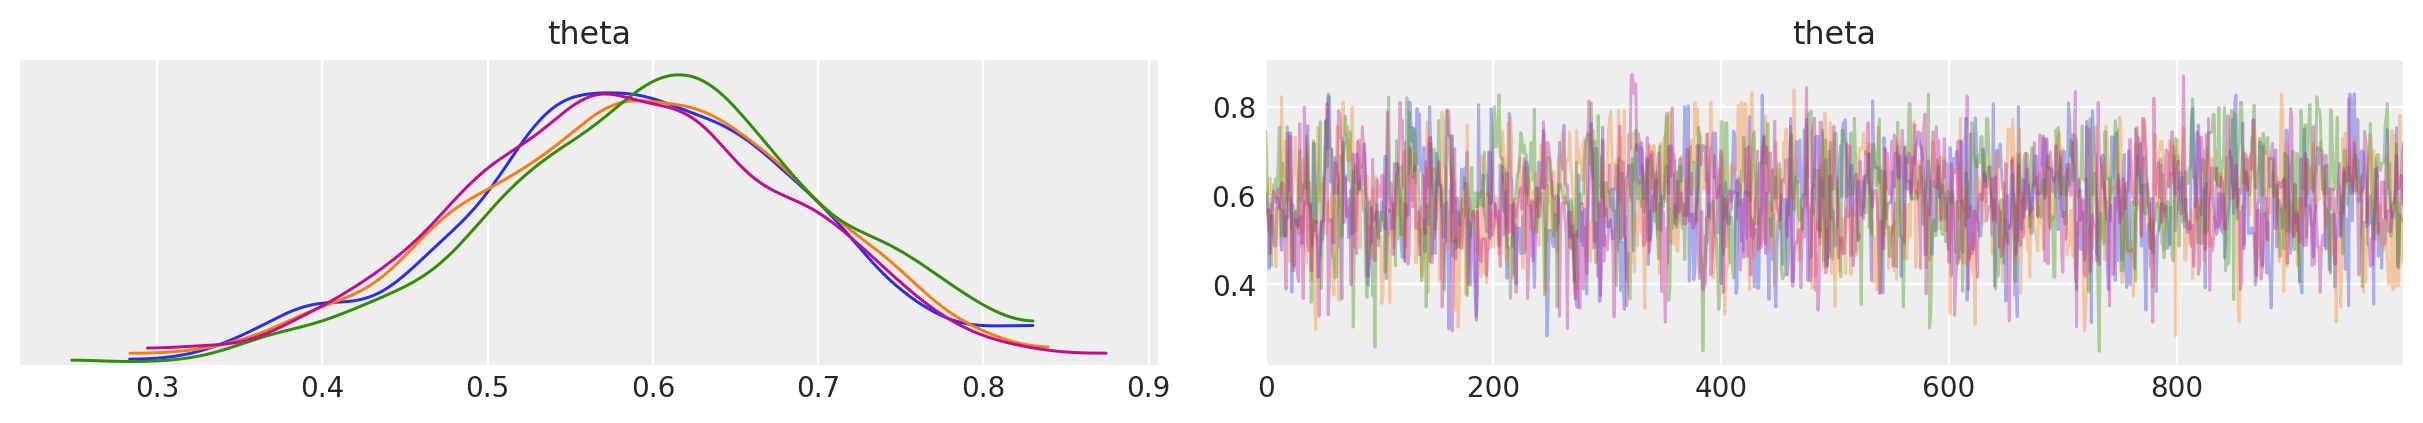

In [13]:
# Inferring a Common Rate, With Posterior Predictive
k1 = 2
n1 = 13
k2 = 10
n2 = 10

with pm.Model() as model5:
    # prior
    theta = pm.Beta("theta", alpha=1, beta=1)
    # observed
    x1 = pm.Binomial("x1", n=n2, p=theta, observed=k1)
    x2 = pm.Binomial("x2", n=n2, p=theta, observed=k2)
    # inference
    trace5 = pm.sample()
    # prediction (sample from trace)
    ppc5 = pm.sample_posterior_predictive(trace5)

idata5 = az.from_pymc3(trace5)
az.plot_trace(idata5, var_names=["theta"]);

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


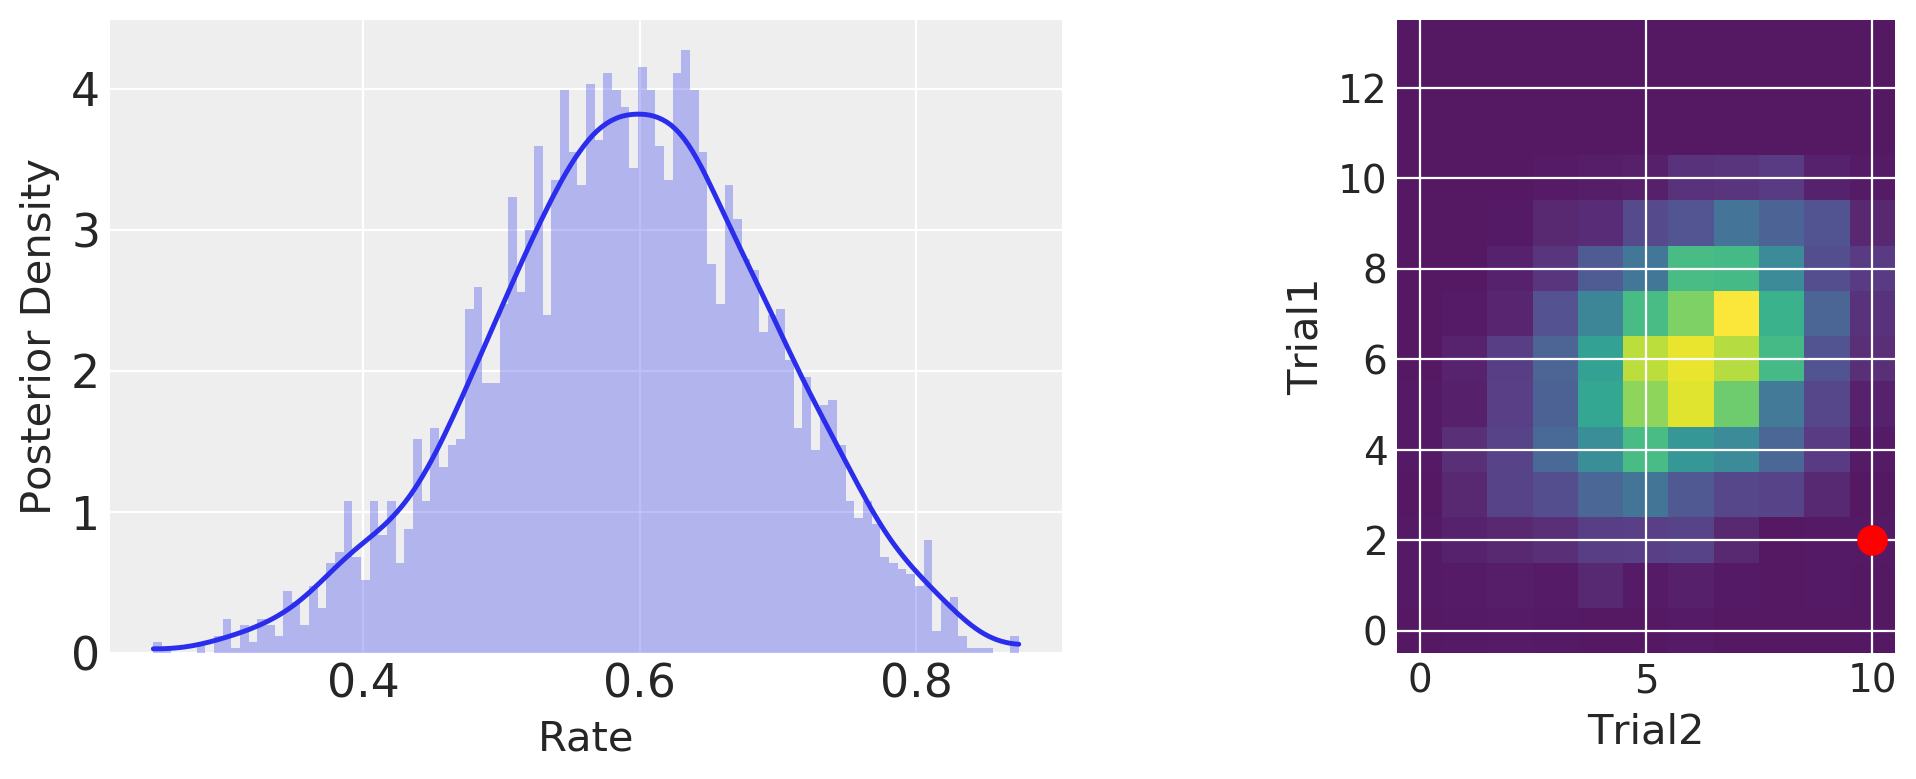

In [14]:
fig = plt.figure(figsize=(12, 4))
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 3])
ax0 = plt.subplot(gs[0])

az.plot_kde(trace5["theta"], ax=ax0)
ax0.hist(trace5["theta"], bins=100, density=1, alpha=0.3)
ax0.set_xlabel("Rate")
ax0.set_ylabel("Posterior Density")

ax1 = plt.subplot(gs[1])
predx1 = ppc5["x1"]
predx2 = ppc5["x2"]

A = sparse.csc_matrix(
    (np.ones(len(predx1)), (predx1, predx2)), shape=(n1 + 1, n2 + 1)
).todense()
ax1.imshow(A, alpha=0.9, origin="lower", cmap="viridis")
ax1.scatter(k2, k1, s=100, c=[1, 0, 0])
ax1.set_xlabel("Trial2")
ax1.set_ylabel("Trial1")

plt.tight_layout();

## 3.6 Joint distributions

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [theta]
>Metropolis: [TotalN]


Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 8 seconds.
The acceptance probability does not match the target. It is 0.902441611369047, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.630426559705178, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


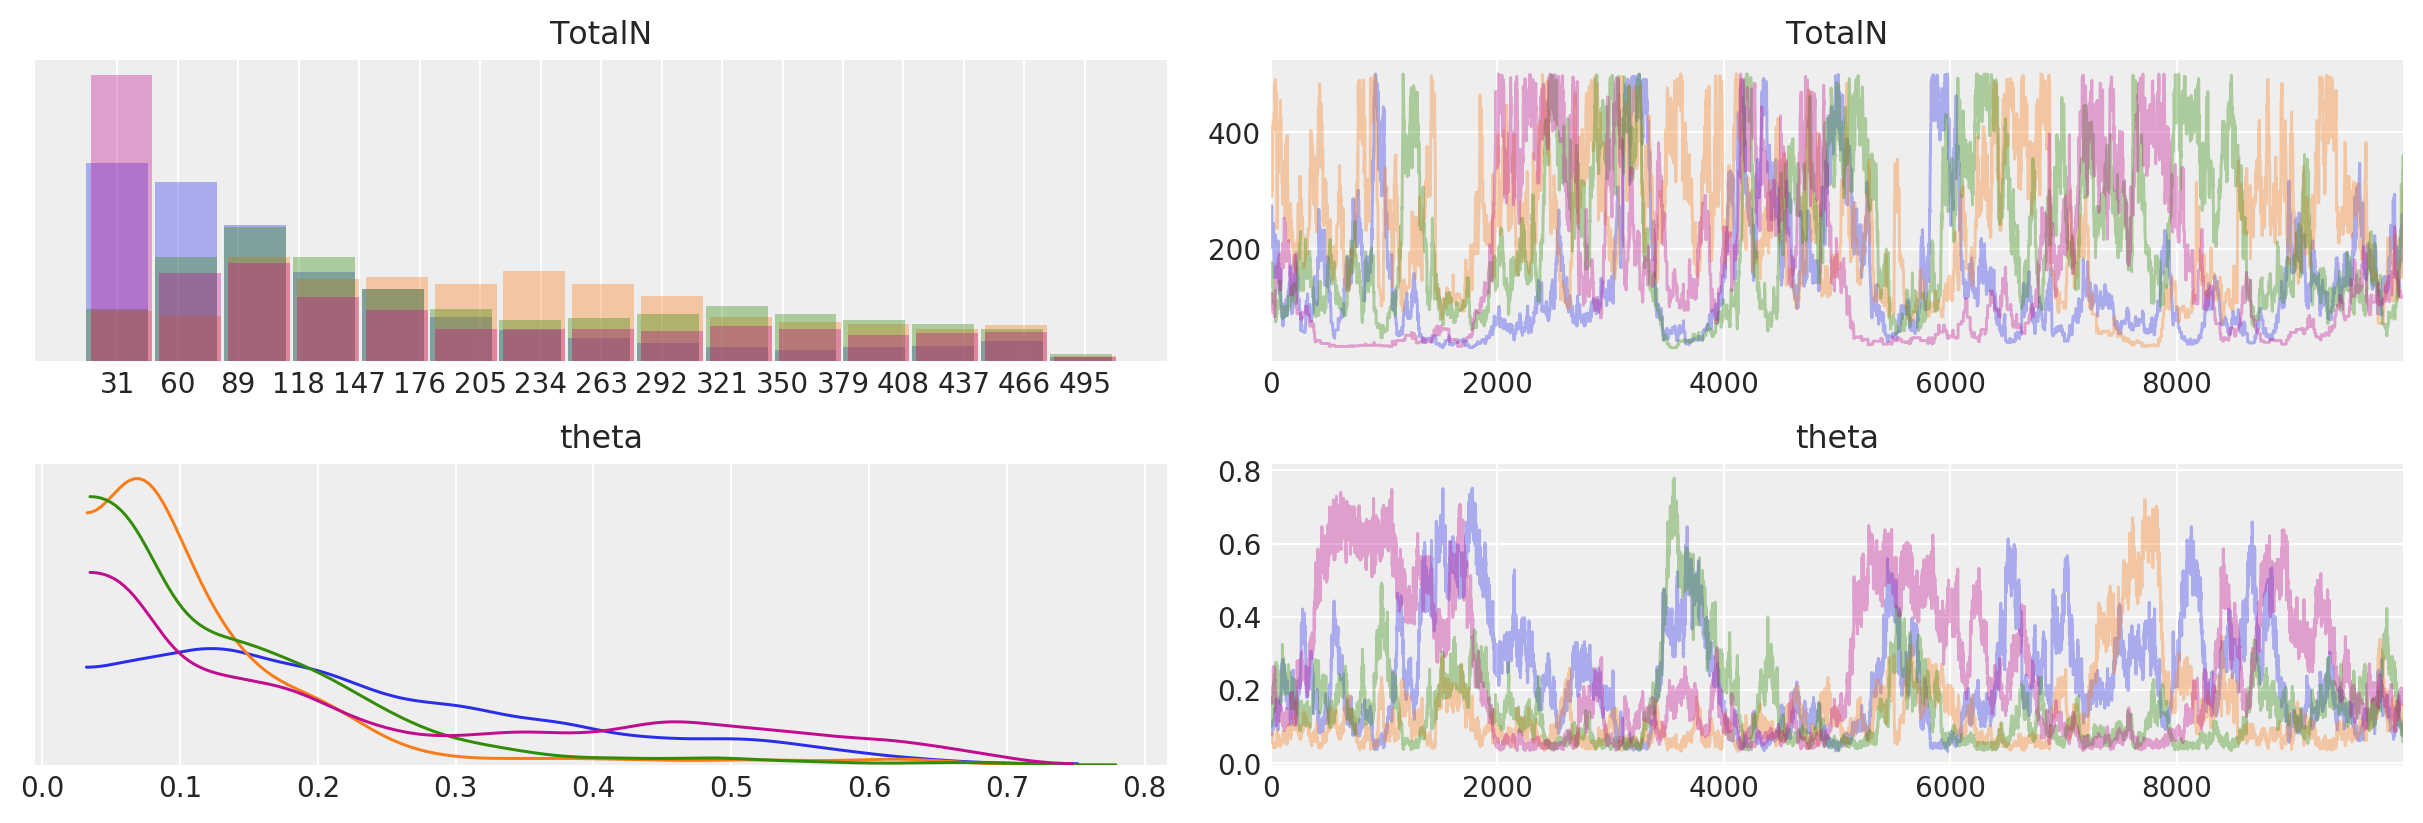

In [15]:
# the Survey example in the book
k = np.array([16, 18, 22, 25, 27])
nmax = 500
m = len(k)

with pm.Model() as model6:
    # prior
    theta = pm.Beta("theta", alpha=1, beta=1)
    TotalN = pm.DiscreteUniform("TotalN", lower=1, upper=nmax)
    # observed
    x = pm.Binomial("x", n=TotalN, p=theta, observed=k)
    # inference
    trace6 = pm.sample(10_000, tune=2000)

idata6 = az.from_pymc3(trace6)
az.plot_trace(idata6);

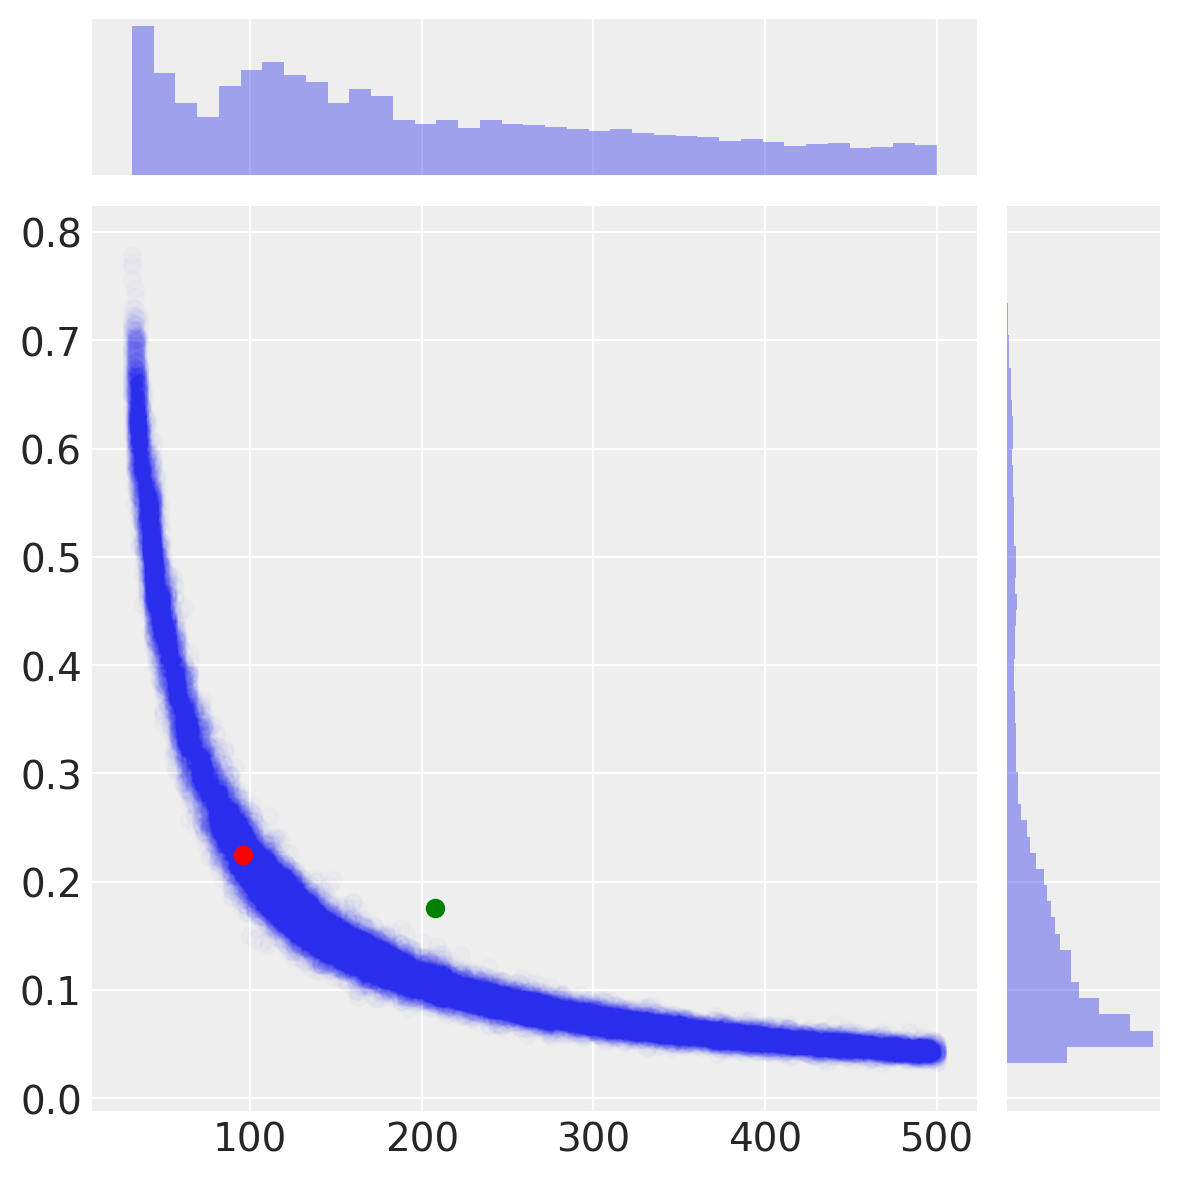

In [16]:
burnin = 9000
thetapost = trace6["theta"][burnin:]
npost = trace6["TotalN"][burnin:]

g = sns.jointplot(npost, thetapost, kind="scatter", stat_func=None, alpha=0.01)

cc = -float("Inf")
ind = 0

for i in range(0, len(npost)):
    logL = 0
    for j in k:
        logL = (
            logL
            + special.gammaln(npost[i] + 1)
            - special.gammaln(j + 1)
            - special.gammaln(npost[i] - j + 1)
        )
        logL = (
            logL + j * np.log(thetapost[i]) + (npost[i] - j) * np.log(1 - thetapost[i])
        )

    if logL > cc:
        ind = i
        cc = logL

g.ax_joint.plot(np.mean(npost), np.mean(thetapost), "o", color="g")
g.ax_joint.plot(npost[ind], thetapost[ind], "o", color="r");

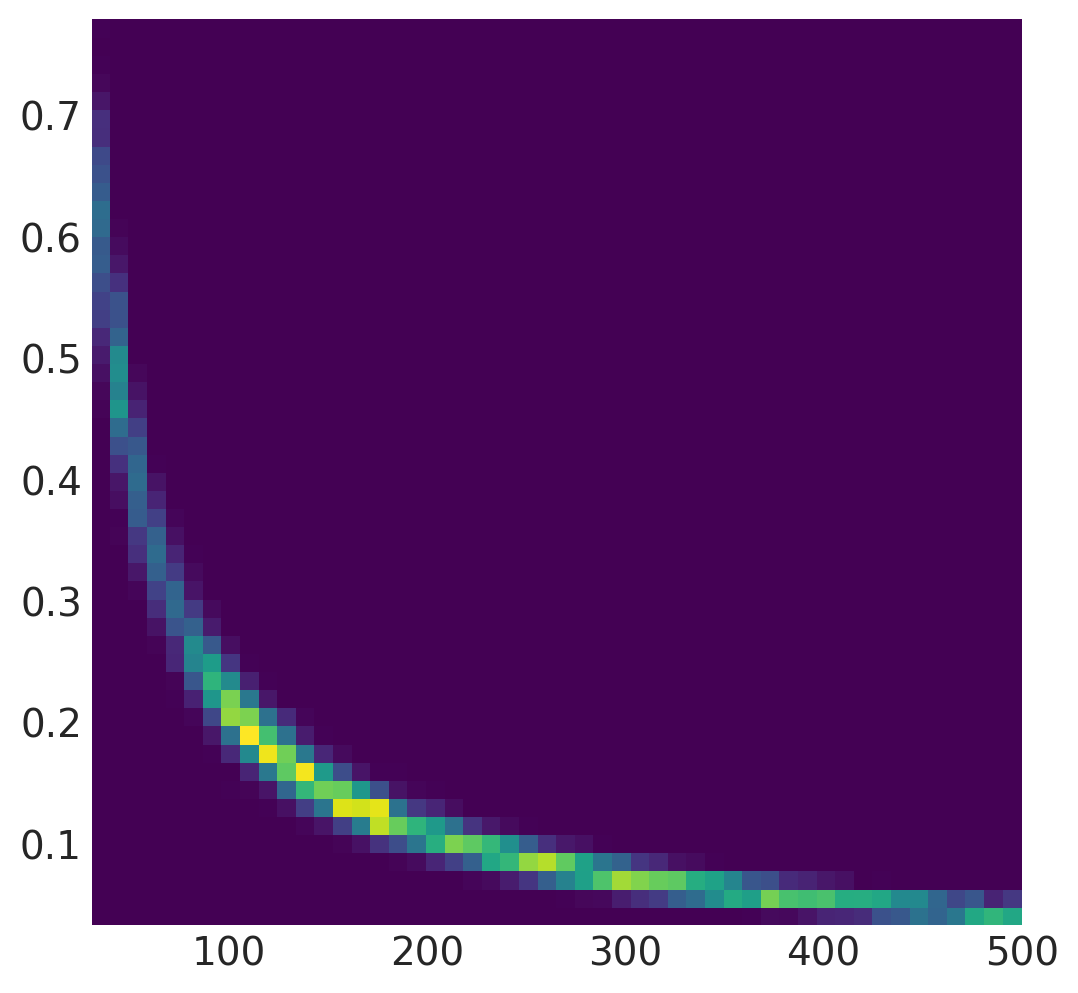

In [17]:
plt.figure(1, figsize=(6, 6))
plt.hist2d(npost, thetapost, bins=50, cmap="viridis");

### Note from Junpeng Lao
It is obvious from the above posterior plot that the geometry of the posterior is quite nasty. We can see that in the trace as well: the mixing is quite poor, with strong autocorrelation. There is no divergence warning, but it could just be that PyMC3 is mixing Metropolis and NUTS together due to the discrete variable. 

In this particular case, it is not a big deal as we can visualize the posterior directly. However, when we are sampling larger models, it is definitely going to be a problem.
Actually, we don't necessary need to use `DiscreteUniform` for `TotalN`, as the computation of logp in Binomial doesn't require n to be an integer.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [TotalN, theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
There were 104 divergences after tuning. Increase `target_accept` or reparameterize.
There were 73 divergences after tuning. Increase `target_accept` or reparameterize.
There were 97 divergences after tuning. Increase `target_accept` or reparameterize.
There were 83 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


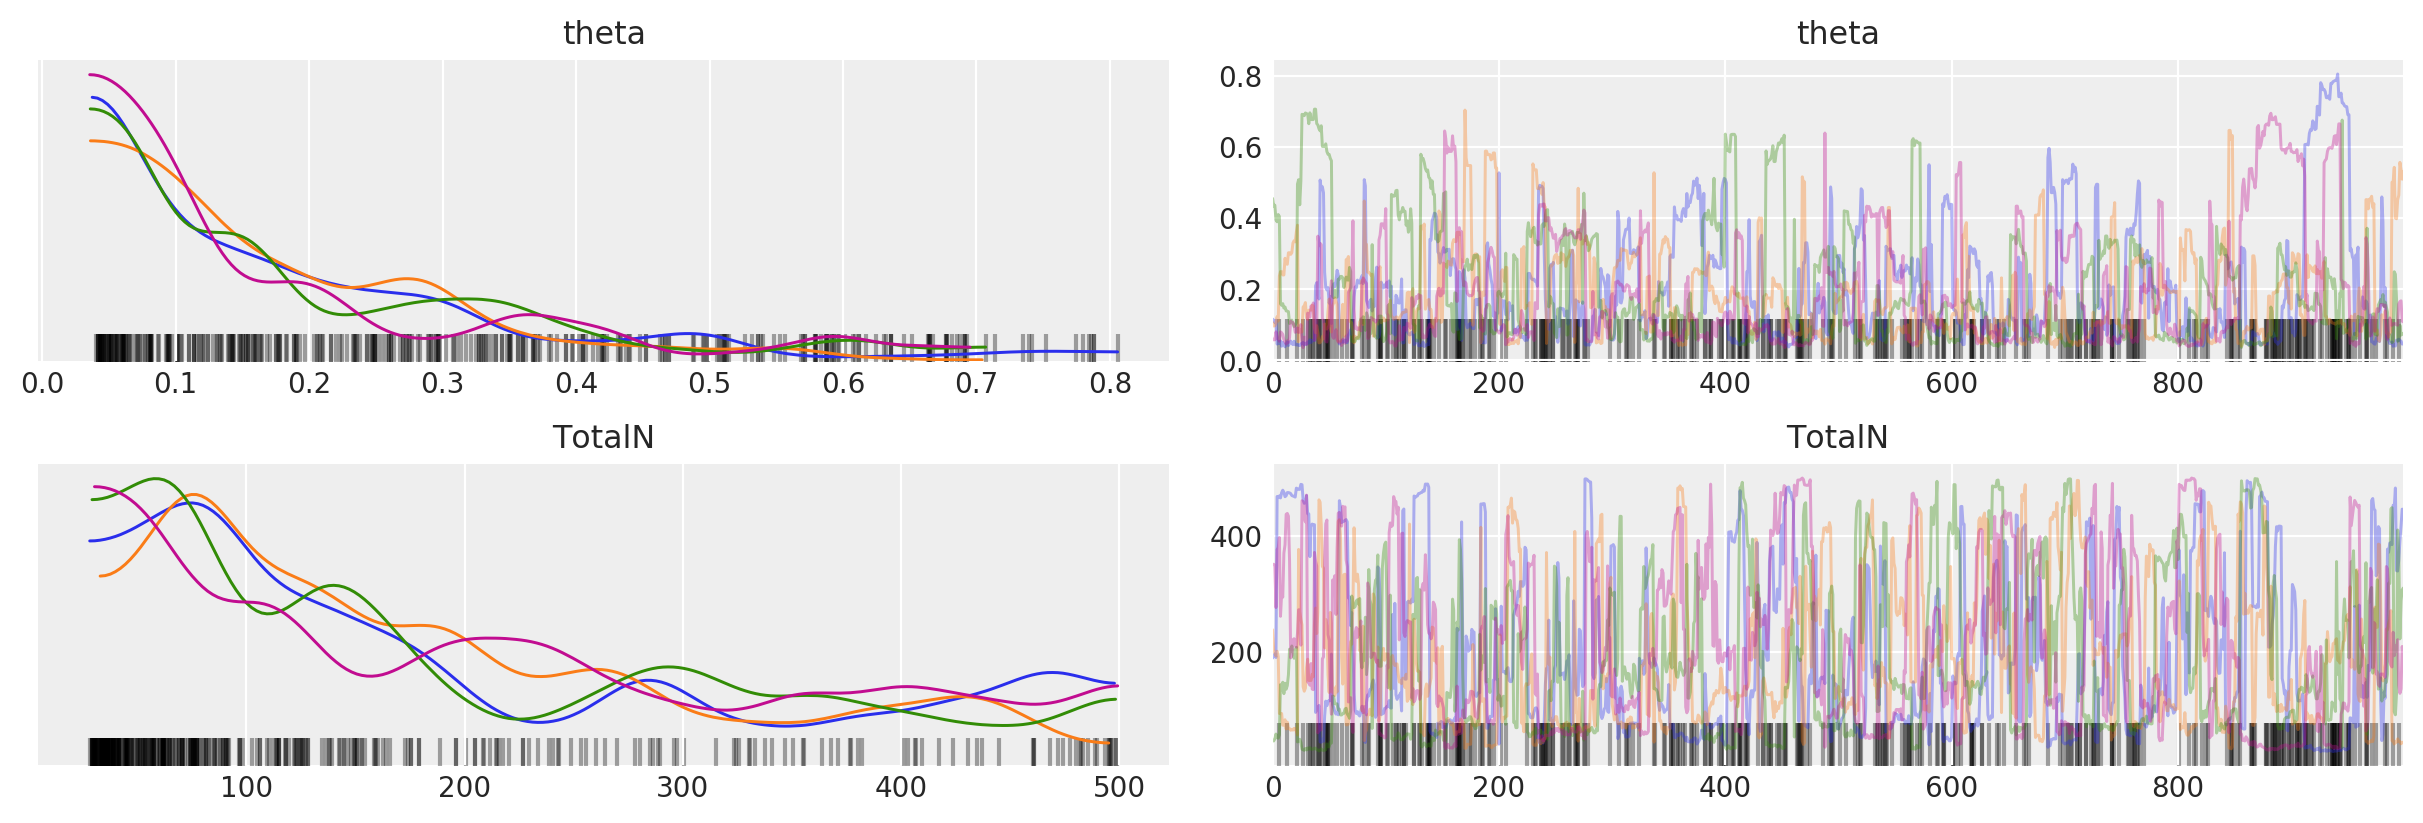

In [18]:
with pm.Model() as model6_:
    # prior
    theta = pm.Beta("theta", alpha=1, beta=1)
    TotalN = pm.Uniform("TotalN", lower=1, upper=nmax)
    # observed
    x = pm.Binomial("x", n=TotalN, p=theta, observed=k)
    # inference
    trace6_ = pm.sample()

idata6_ = az.from_pymc3(trace6_)
az.plot_trace(idata6_);

Not too surprisingly, we can see divergence warnings. We can further visualize them:

Number of divergences: 357
Percentage of divergent samples: 35.70


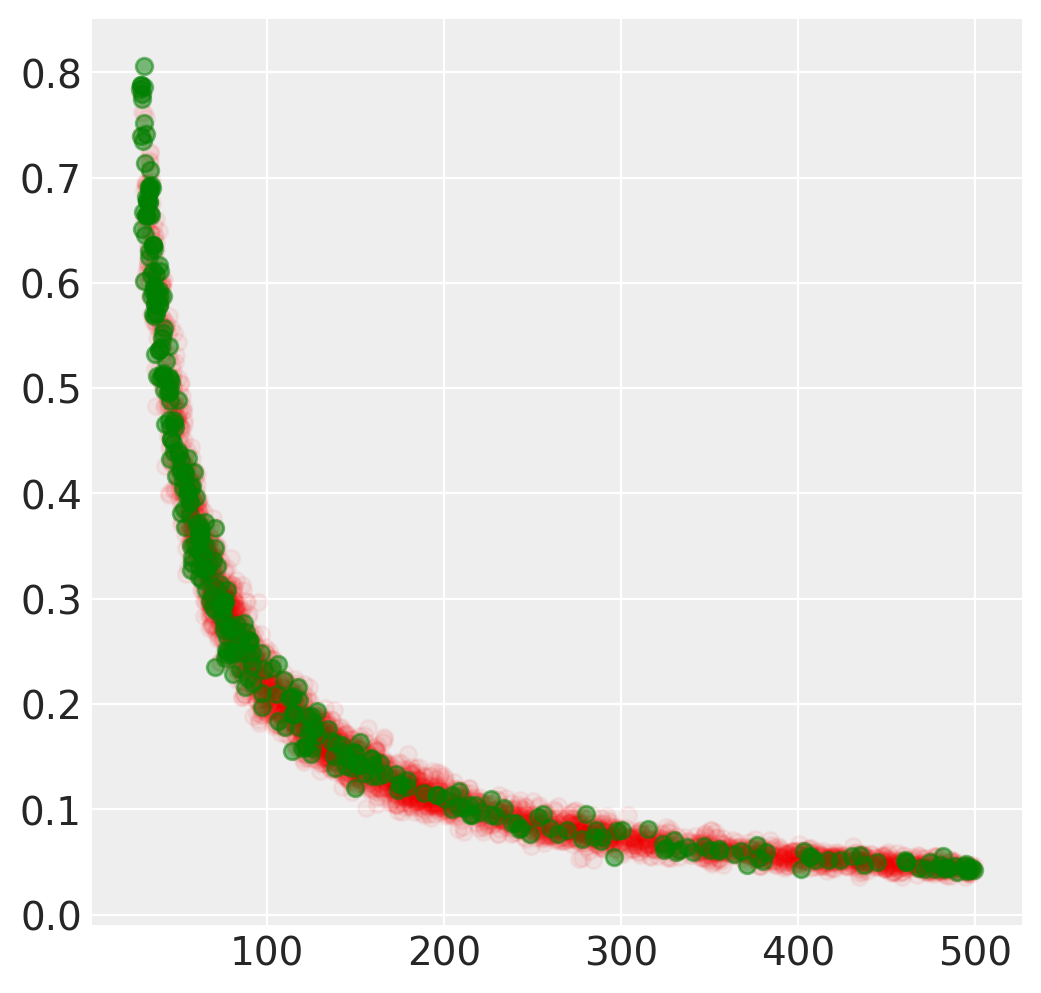

In [19]:
# display the total number and percentage of divergences
divergent = trace6_["diverging"]
print("Number of divergences: %d" % divergent.nonzero()[0].size)
divperc = divergent.nonzero()[0].size * 100 / len(trace6_)
print("Percentage of divergent samples: %.2f" % divperc)

# scatter plot between theta and N
# for the identifcation of the problematic neighborhoods in parameter space
theta_tr = trace6_["theta"]
totaln_tr = trace6_["TotalN"]
plt.figure(figsize=(6, 6))
plt.scatter(totaln_tr[divergent == 0], theta_tr[divergent == 0], color="r", alpha=0.05)
plt.scatter(totaln_tr[divergent == 1], theta_tr[divergent == 1], color="g", alpha=0.5);

It confirms our intuition that in the high curvature area (tails), our sampler is going to have difficulties.

In [20]:
%load_ext watermark
%watermark -n -u -v -iv -w

pandas  1.0.3
numpy   1.18.1
arviz   0.7.0
seaborn 0.10.0
pymc3   3.8
last updated: Fri Apr 24 2020 

CPython 3.7.7
IPython 7.13.0
watermark 2.0.2
